# Compare linear regression vs. deep neural network

In [2]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import argparse
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from keras.callbacks import History
import numpy as np
from sklearn.model_selection import train_test_split, KFold

import ray
from ray import tune
from helper_functions.scan_helper_functions import train_forward_model, load_dataset, build_forward_surrogate, calculate_metrics
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from keras.callbacks import CSVLogger
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from mllib.model import KerasSurrogate, AdaptiveMinMaxScaler
from helper_functions.scan_helper_functions import AdjustedRSquared

# Load and prepare data

In [3]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))

In [4]:
datafile = directory +'/aerosol_data/phase_data.hdf5'
result_dir = directory +'/aerosol_results/forward_model_test'
result_dir_iv = directory +'/aerosol_results/invertible_model_test'
modeltype =  'forward'
modeltype_iv = 'invertible'
history_dir = f'{result_dir}/histories'

In [5]:
config_linear = {'width':0, 'depth':0, 'lr': 0.001,'batch_size':256,'datafile': datafile}
config_dnn = {'width':160, 'depth':6, 'lr': 0.001,'batch_size':256,'datafile': datafile}
config_iv = {'n_blocks': 4, 'n_depth':3, 'n_width':20, 'learning_rate':0.001, 'batch_size':128, 'datafile':datafile}

In [6]:
seed = config_linear.get('seed', 49857)
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
dvar_train, dvar_val, dvar_test, qoi_train, qoi_val, qoi_test = load_dataset(datafile)
qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [8]:
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True,inplace=True)
indices = qoi_test.index
qoi_test = qoi_test.values[indices]
indices = dvar_test.index
dvar_test = dvar_test.values[indices]


In [7]:
n_in = dvar_train.shape[1]

# Build and train the model

In [8]:
surr_linear = build_forward_surrogate(dvar_train.shape[1],qoi_train.shape[1],config_linear)
surr_dnn = build_forward_surrogate(dvar_train.shape[1],qoi_train.shape[1],config_dnn)

[]
[]


In [9]:
csv_logger_linear = CSVLogger('training_linear.log', separator=',', append=False)
hist_linear = surr_linear.fit(dvar_train,qoi_train,X_val=dvar_val,y_val=qoi_val,
        batch_size=config_linear['batch_size'],epochs=100, callbacks = [csv_logger_linear])

Epoch 1/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3239 - MAE: 0.5201 - MAPE: 3564.1544 - adjusted_r2: -7.7038 - val_loss: 0.2113 - val_MAE: 0.4135 - val_MAPE: 65.5577 - val_adjusted_r2: -4.7832
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1440 - MAE: 0.3325 - MAPE: 6569.4638 - adjusted_r2: -2.9079 - val_loss: 0.0964 - val_MAE: 0.2683 - val_MAPE: 51.0171 - val_adjusted_r2: -1.6331
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0705 - MAE: 0.2259 - MAPE: 8429.9295 - adjusted_r2: -0.8961 - val_loss: 0.0530 - val_MAE: 0.1943 - val_MAPE: 45.5739 - val_adjusted_r2: -0.4438
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0436 - MAE: 0.1742 - MAPE: 10327.2395 - adjusted_r2: -0.1680 - val_loss: 0.0371 - val_MAE: 0.1594 - val_MAPE: 43.3219 - val_adjusted_r2: -0.0075
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0334 - MAE: 0.1494 - MAPE: 10812.2035 - adjusted

99/99 [==============================] - 0s 1ms/step - loss: 0.0128 - MAE: 0.0909 - MAPE: 13683.6621 - adjusted_r2: 0.6617 - val_loss: 0.0126 - val_MAE: 0.0904 - val_MAPE: 33.5167 - val_adjusted_r2: 0.6622
Epoch 76/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0128 - MAE: 0.0909 - MAPE: 13627.7056 - adjusted_r2: 0.6613 - val_loss: 0.0126 - val_MAE: 0.0898 - val_MAPE: 33.6573 - val_adjusted_r2: 0.6634
Epoch 77/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0128 - MAE: 0.0909 - MAPE: 13599.2404 - adjusted_r2: 0.6626 - val_loss: 0.0126 - val_MAE: 0.0899 - val_MAPE: 33.6458 - val_adjusted_r2: 0.6633
Epoch 78/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0128 - MAE: 0.0908 - MAPE: 13650.4342 - adjusted_r2: 0.6623 - val_loss: 0.0126 - val_MAE: 0.0902 - val_MAPE: 33.5595 - val_adjusted_r2: 0.6625
Epoch 79/100
99/99 [==============================] - 0s 1ms/step - loss: 0.0128 - MAE: 0.0908 - MAPE: 13643.1926 - adjusted_r2: 0.6622 -

In [10]:
csv_logger_dnn = CSVLogger('training_dnn.log', separator=',', append=False)
hist_dnn = surr_dnn.fit(dvar_train,qoi_train,X_val=dvar_val,y_val=qoi_val,
        batch_size=config_dnn['batch_size'],epochs=100, callbacks = [csv_logger_dnn])

Epoch 1/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0577 - MAE: 0.1534 - MAPE: 4839.6893 - adjusted_r2: -0.5348 - val_loss: 0.0036 - val_MAE: 0.0469 - val_MAPE: 9.8559 - val_adjusted_r2: 0.9025
Epoch 2/100
99/99 [==============================] - 1s 6ms/step - loss: 0.0020 - MAE: 0.0337 - MAPE: 2222.2081 - adjusted_r2: 0.9446 - val_loss: 7.8636e-04 - val_MAE: 0.0210 - val_MAPE: 4.7052 - val_adjusted_r2: 0.9785
Epoch 3/100
99/99 [==============================] - 1s 6ms/step - loss: 5.2187e-04 - MAE: 0.0167 - MAPE: 1570.0698 - adjusted_r2: 0.9861 - val_loss: 3.7603e-04 - val_MAE: 0.0140 - val_MAPE: 3.1172 - val_adjusted_r2: 0.9899
Epoch 4/100
99/99 [==============================] - 1s 6ms/step - loss: 2.9993e-04 - MAE: 0.0124 - MAPE: 1059.8088 - adjusted_r2: 0.9920 - val_loss: 3.4178e-04 - val_MAE: 0.0137 - val_MAPE: 2.8272 - val_adjusted_r2: 0.9909
Epoch 5/100
99/99 [==============================] - 1s 6ms/step - loss: 2.2551e-04 - MAE: 0.0109 - MAPE: 819.1434 

Epoch 38/100
99/99 [==============================] - 1s 6ms/step - loss: 5.4471e-05 - MAE: 0.0054 - MAPE: 396.1288 - adjusted_r2: 0.9986 - val_loss: 6.6201e-05 - val_MAE: 0.0067 - val_MAPE: 1.5572 - val_adjusted_r2: 0.9982
Epoch 39/100
99/99 [==============================] - 1s 6ms/step - loss: 7.8446e-05 - MAE: 0.0068 - MAPE: 414.8041 - adjusted_r2: 0.9979 - val_loss: 3.3324e-05 - val_MAE: 0.0044 - val_MAPE: 0.9760 - val_adjusted_r2: 0.9991
Epoch 40/100
99/99 [==============================] - 1s 6ms/step - loss: 2.8968e-05 - MAE: 0.0039 - MAPE: 496.2892 - adjusted_r2: 0.9992 - val_loss: 2.2034e-05 - val_MAE: 0.0034 - val_MAPE: 0.7160 - val_adjusted_r2: 0.9994
Epoch 41/100
99/99 [==============================] - 1s 6ms/step - loss: 6.0456e-05 - MAE: 0.0055 - MAPE: 421.5989 - adjusted_r2: 0.9984 - val_loss: 3.0242e-05 - val_MAE: 0.0042 - val_MAPE: 0.8049 - val_adjusted_r2: 0.9992
Epoch 42/100
99/99 [==============================] - 1s 6ms/step - loss: 3.3691e-05 - MAE: 0.0043 - MAP

In [11]:
log_data_linear = pd.read_csv('training_linear.log', sep=',', engine='python')
log_data_dnn = pd.read_csv('training_dnn.log', sep=',', engine='python')

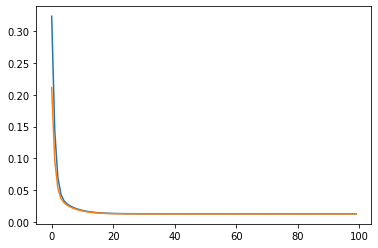

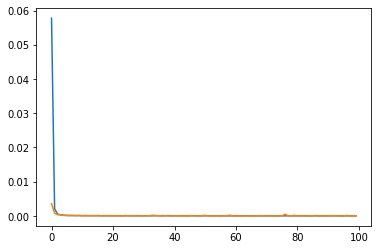

In [12]:
plt.figure()
plt.plot(log_data_linear['epoch'], log_data_linear['loss'])
plt.plot(log_data_linear['epoch'], log_data_linear['val_loss'])
plt.figure()
plt.plot(log_data_dnn['epoch'], log_data_dnn['loss'])
plt.plot(log_data_dnn['epoch'], log_data_dnn['val_loss'])

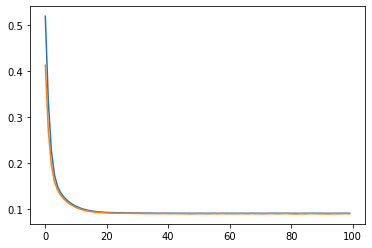

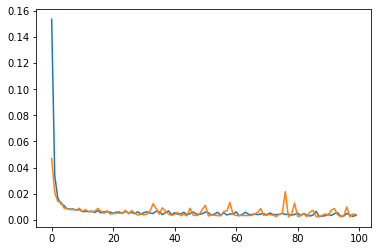

In [13]:
plt.figure()
plt.plot(log_data_linear['epoch'], log_data_linear['MAE'])
plt.plot(log_data_linear['epoch'], log_data_linear['val_MAE'])
plt.figure()
plt.plot(log_data_dnn['epoch'], log_data_dnn['MAE'])
plt.plot(log_data_dnn['epoch'], log_data_dnn['val_MAE'])

In [14]:
log_data_linear['MAPE']

0      3564.154441
1      6569.463831
2      8429.929516
3     10327.239539
4     10812.203515
          ...     
95    13669.671316
96    13703.946936
97    13675.482007
98    13592.772512
99    13635.209227
Name: MAPE, Length: 100, dtype: float64

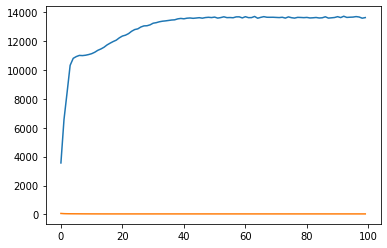

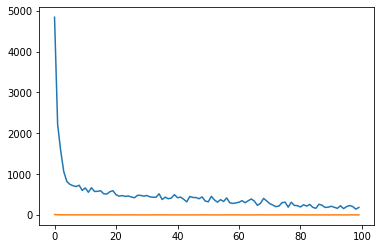

In [15]:
plt.figure()
plt.plot(log_data_linear['epoch'], log_data_linear['MAPE'])
plt.plot(log_data_linear['epoch'], log_data_linear['val_MAPE'])
plt.figure()
plt.plot(log_data_dnn['epoch'], log_data_dnn['MAPE'])
plt.plot(log_data_dnn['epoch'], log_data_dnn['val_MAPE'])

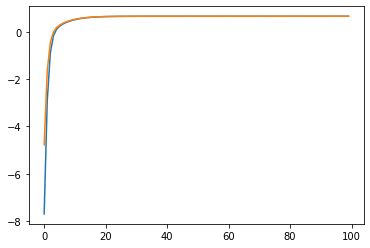

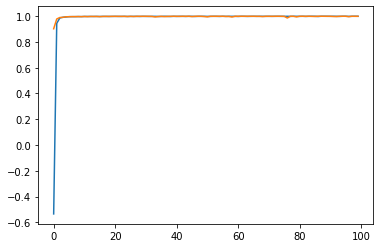

In [16]:
plt.figure()
plt.plot(log_data_linear['epoch'], log_data_linear['adjusted_r2'])
plt.plot(log_data_linear['epoch'], log_data_linear['val_adjusted_r2'])
plt.figure()
plt.plot(log_data_dnn['epoch'], log_data_dnn['adjusted_r2'])
plt.plot(log_data_dnn['epoch'], log_data_dnn['val_adjusted_r2'])

In [17]:
qoi_pred_train_linear = surr_linear.predict(dvar_train)
qoi_pred_val_linear = surr_linear.predict(dvar_val)
qoi_pred_test_linear = surr_linear.predict(dvar_test)

In [18]:
qoi_pred_train_dnn = surr_dnn.predict(dvar_train)
qoi_pred_val_dnn = surr_dnn.predict(dvar_val)
qoi_pred_test_dnn = surr_dnn.predict(dvar_test)

In [19]:
n_in = dvar_train.shape[1]

In [20]:
metrics_train_linear = calculate_metrics(qoi_train, qoi_pred_train_linear, n_in)
metrics_val_linear = calculate_metrics(qoi_val, qoi_pred_val_linear, n_in)
metrics_test_linear = calculate_metrics(qoi_test, qoi_pred_test_linear, n_in)


In [21]:
metrics_train_dnn = calculate_metrics(qoi_train, qoi_pred_train_dnn, n_in)
metrics_val_dnn = calculate_metrics(qoi_val, qoi_pred_val_dnn, n_in)
metrics_test_dnn = calculate_metrics(qoi_test, qoi_pred_test_dnn, n_in)


In [22]:
metrics_train_linear

{'MAE': 0.7881462628773643,
 'MAPE': 4.3995029257859954,
 'median_percentile_max_error': 10.889567506434588,
 '90_percentile_max_error': 18.298748759860146,
 'r2': 0.6717697240692703,
 'r2_adj': 0.6717049537093502}

In [23]:
metrics_val_linear

{'MAE': 0.7796822807320889,
 'MAPE': 4.362355292714866,
 'median_percentile_max_error': 10.844104856161147,
 '90_percentile_max_error': 18.250528999316792,
 'r2': 0.6723781941108934,
 'r2_adj': 0.6721194091141406}

In [24]:
metrics_test_linear

{'MAE': 0.7857765639190704,
 'MAPE': 4.3855050051028694,
 'median_percentile_max_error': 10.887261931074551,
 '90_percentile_max_error': 18.29672210413699,
 'r2': 0.6773868804114371,
 'r2_adj': 0.6771830561003501}

In [25]:
metrics_train_dnn

{'MAE': 0.03458307802839414,
 'MAPE': 0.20602276678849277,
 'median_percentile_max_error': 0.9117160308083057,
 '90_percentile_max_error': 1.655054068810433,
 'r2': 0.999401131689817,
 'r2_adj': 0.9994010135138934}

In [26]:
metrics_val_dnn

{'MAE': 0.03504957529794837,
 'MAPE': 0.20907102925663998,
 'median_percentile_max_error': 0.9109577950364243,
 '90_percentile_max_error': 1.6620928479246873,
 'r2': 0.9993756353189509,
 'r2_adj': 0.999375142139898}

In [27]:
metrics_test_dnn

{'MAE': 0.034860388075307884,
 'MAPE': 0.20778531467990274,
 'median_percentile_max_error': 0.9107164142989704,
 '90_percentile_max_error': 1.6786340157911595,
 'r2': 0.9993989085812711,
 'r2_adj': 0.9993985288166649}

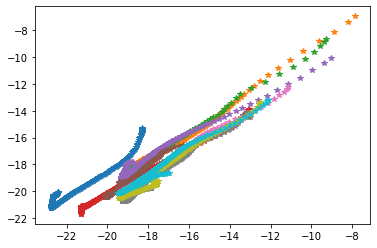

In [28]:
for i in range(10):
    plt.plot(qoi_test[i], qoi_pred_test_linear[i],'*')

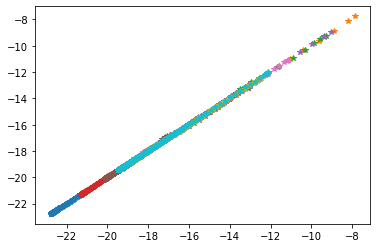

In [29]:
for i in range(10):
    plt.plot(qoi_test[i], qoi_pred_test_dnn[i],'*')

In [31]:
qoi_test

array([[-18.28083185, -18.28274656, -18.28868803, ..., -22.43723128,
        -22.42684961, -22.42044266],
       [ -7.86008778,  -8.18372546,  -8.86973384, ..., -16.48134933,
        -16.74225796, -16.80158957],
       [ -9.29909509,  -9.36157032,  -9.54944206, ..., -18.77950084,
        -18.77950084, -18.77950084],
       ...,
       [ -9.51678401,  -9.71488576, -10.1460688 , ..., -16.78388061,
        -16.79495618, -16.69784272],
       [ -7.03081597,  -7.59027909,  -8.55396092, ..., -14.09184394,
        -14.16836424, -14.38132049],
       [ -8.40341818,  -8.80787977,  -9.51218898, ..., -15.0044634 ,
        -15.10915281, -15.27838363]])

No handles with labels found to put in legend.


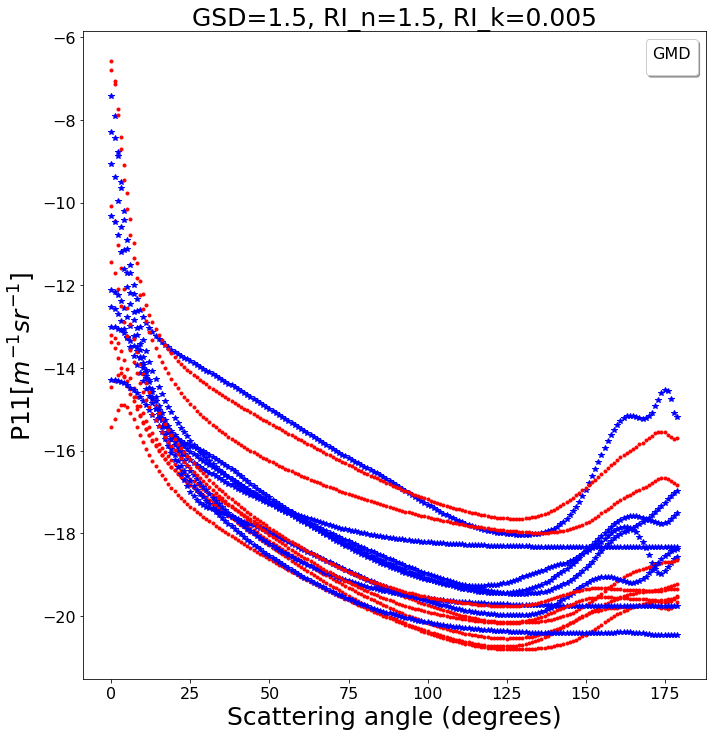

In [37]:
presentation_plot_index = [0,1,3,4,5,6]
#presentation_plot_index = [7,8,9,10,11,12,13,14]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(qoi_test[0])),qoi_test[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_test_linear[0])),qoi_pred_test_linear[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')

No handles with labels found to put in legend.


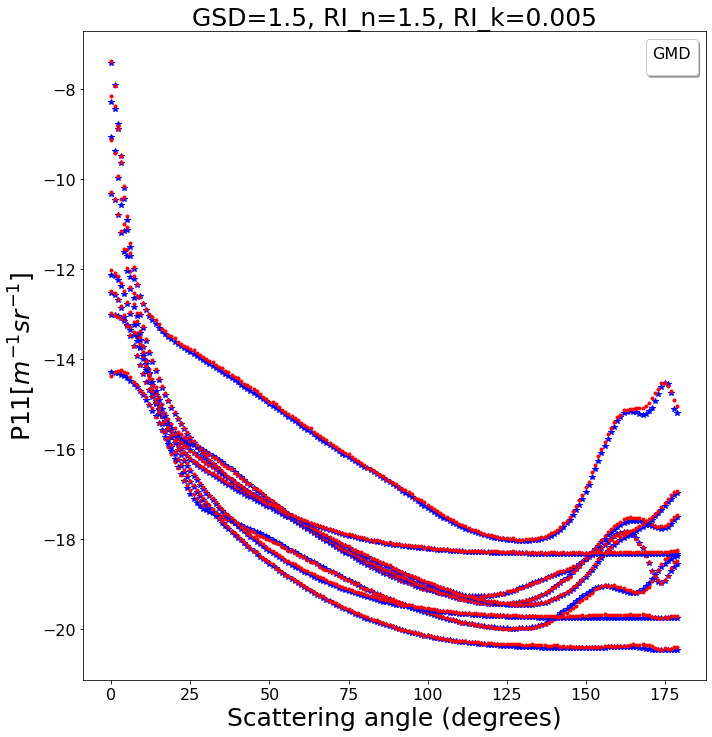

In [38]:
presentation_plot_index = [0,1,3,4,5,6]
#presentation_plot_index = [7,8,9,10,11,12,13,14]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(qoi_test[0])),qoi_test[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_test_dnn[0])),qoi_pred_test_dnn[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')

In [ ]:
print(surr_linear.model.summary())

In [ ]:
print(surr_dnn.model.summary())

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(surr_linear.model, show_shapes=True,show_layer_names=True)

In [ ]:
plot_model(surr_dnn.model,show_shapes=True,show_layer_names=True)

# Invertible Model

In [61]:
datafile = config_iv['datafile']
n_blocks = config_iv['n_depth']
n_width = config_iv['n_width']
n_depth = config_iv['n_depth']
nominal_dim = 182
epochs = 3
surr = InvertibleNetworkSurrogate.from_config(
        x_dim=dvar_train.shape[1],
        y_dim=qoi_train.shape[1],
        z_dim=1,
        nominal_dim=nominal_dim,
        number_of_blocks=n_blocks,
        coefficient_network_units=[n_width for i in range(n_depth)] + [nominal_dim // 2],
        coefficient_network_activations=['relu' for i in range(n_depth)] + ['linear'],
        share_s_and_t=True,
        preprocessor_x=AdaptiveMinMaxScaler(),
        preprocessor_y=AdaptiveMinMaxScaler(),
        name='surrogate_model',
        sampling_distribution='uniform',
        version=f'TensorFlow  version: {tf.__version__}'
    )

In [62]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}

In [63]:
tensorboard_dir = f'{result_dir_iv}/tensorboard'
os.makedirs(tensorboard_dir)

FileExistsError: [Errno 17] File exists: '/data/user/boiger_r/aerosol/aerosol_results/invertible_model_test/tensorboard'

In [64]:
params = {
    'tensorboard_dir': tensorboard_dir,
    'optimizer': tf.keras.optimizers.Adam(learning_rate=config_iv['learning_rate']),
#    'sampling_distribution': 'uniform',
    'loss_weight_artificial': 1.0,
    'loss_weight_reconstruction': 10.0,
    'loss_weight_x': 400,
    'loss_weight_y': 4,
    'loss_weight_z': 400,
}


surr.fit(dvar_train,
                 qoi_train,
                 X_val=dvar_val,
                 y_val=qoi_val,
                 batch_size=config_iv['batch_size'],
                 epochs=1,
                 **params)

/psi/home/boiger_r/.local/lib/python3.7/site-packages/tensorflow/python/autograph/operators/control_flow.py:684: UserWarning: Seed 49857 from outer graph might be getting used by function tf_data_experimental_scan_scan_body, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  ds = _general_purpose_scan(ds, init_vars, scan_body)


Total number of batches: 198


In [65]:
dvar_pred_train = surr.sample(qoi_train, batch_size=config_iv['batch_size'])
dvar_pred_val = surr.sample(qoi_val, batch_size=config_iv['batch_size'])


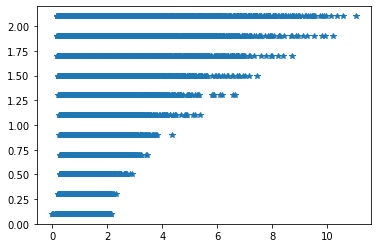

In [66]:
plt.plot(dvar_pred_train.transpose()[0],dvar_train.transpose()[0],'*')

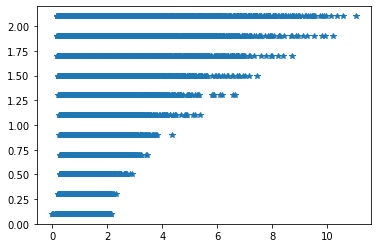

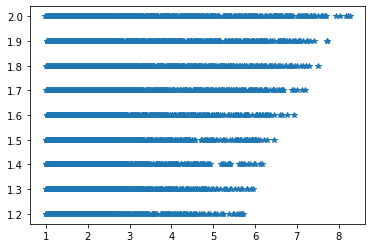

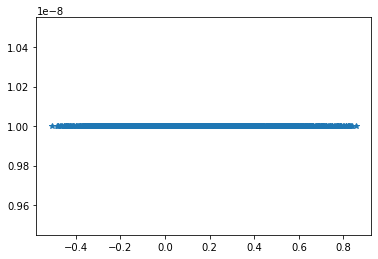

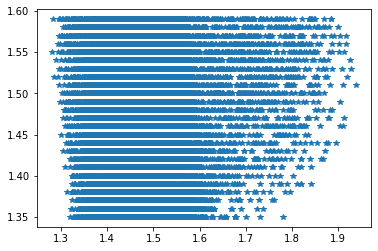

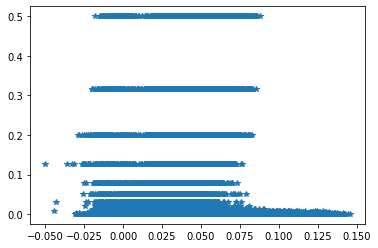

In [67]:
for i in range(5):
    plt.figure()
    plt.plot(dvar_pred_train.transpose()[i],dvar_train.transpose()[i],'*')

In [46]:
dvar_train[0].shape

(5,)